# Simulador de atmósfera

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, AppLayout, GridspecLayout, Layout
import ipywidgets as widgets
from IPython.display import clear_output
from tqdm.notebook import tqdm
import pyOSOAA

In [2]:
list_satellite = np.load('list_satellite.npy',allow_pickle='TRUE').item()
list_satellite[None] = None

In [3]:
list_levels = {"Tope de la atmósfera":1,"Tope del océano":3}
list_aerosols = {"Troposférico":1,
                 "Urbano":2,
                 "Maritimo":3,
                 "Costero":4}

In [5]:
def simulate(satellite="seawifs", sun=30, view=0, phi=90, level=1, chl=1, aero=3, rh=80, aot=0.1, wind=0, ap=False):
    s = pyOSOAA.OSOAA()

    # Oceano
    s.phyto.chl = chl
    s.sea.depth = 100
    s.sea.botalb = 0
    if chl == 0:
        s = pyOSOAA.osoaahelpers.ConfigureOcean(s, ocean_type="black")

    # Superficie
    s.sea.wind = wind
    s.sea.surfalb = 0

    # Modelo de aerosoles de Shetle and Fenn
    s.aer.SetModel(model=2, sfmodel=aero, rh=rh)
    s.aer.aotref = aot

    # Geometria de observacion
    s.view.phi = phi
    s.ang.thetas = sun
    view = view

    s.view.level = level
    
    if ap is True:
        s.ap.SetMot(0)
    # Corremos el código

    rho = []
    for wa in tqdm(list_satellite[satellite], leave=False):
        if ap is True:
            s.ap.SetMot(0)
        s.wa = wa/1e3
        s.run()
        rho = np.append(rho, np.interp(view, s.outputs.vsvza.vza, s.outputs.vsvza.I))
        
    return list_satellite[satellite], rho

In [6]:
def click(b):
    i = 1
    total = toa.value+too.value+aerosol.value+rayleigh.value+2*glint.value
    if total > 0:
        if toa.value:
            print(f"Simulación {i} de {total}...", end="\r")
            wl, rtoa = simulate(satellite=satellite.value, level=1, 
                           chl=chl.value, aero=aero.value, rh=rh.value,
                           aot=aot.value, wind=wind.value,
                           sun=sun.value, view=view.value, phi=phi.value)
            i = i+1
        
        if rayleigh.value:
            print(f"Simulación {i} de {total}...", end="\r")
            wl, rray = simulate(satellite=satellite.value, level=1, 
                               chl=0, aero=3, rh=80,
                               aot=0, wind=0,
                               sun=sun.value, view=view.value, phi=phi.value)
            i = i+1
        
        if aerosol.value:
            print(f"Simulación {i} de {total}...", end="\r")
            wl, raer = simulate(satellite=satellite.value, level=1, 
                               chl=0, aero=aero.value, rh=rh.value,
                               aot=aot.value, wind=0, ap=True,
                               sun=sun.value, view=view.value, phi=phi.value)
            i = i+1
        
        if too.value:
            print(f"Simulación {i} de {total}...", end="\r")
            wl, rtoo = simulate(satellite=satellite.value, level=3, 
                           chl=chl.value, aero=aero.value, rh=rh.value,
                           aot=aot.value, wind=wind.value,
                           sun=sun.value, view=view.value, phi=phi.value)
            i = i+1
            
        if glint.value:
            print(f"Simulación {i} de {total}...", end="\r")
            wl, tmpNO = simulate(satellite=satellite.value, level=1, 
                           chl=0, aero=aero.value, rh=rh.value,
                           aot=aot.value, wind=0)
            i = i+1
            print(f"Simulación {i} de {total}...", end="\r")
            wl, tmpSI = simulate(satellite=satellite.value, level=1, 
                           chl=0, aero=aero.value, rh=rh.value,
                           aot=aot.value, wind=wind.value,
                           sun=sun.value, view=view.value, phi=phi.value)
            rgli = tmpSI-tmpNO
            i = i+1
    clear_output(wait=True)
    display(grid, button)
    
    if total > 0:
        if toa.value:
            plt.plot(wl, rtoa,'o-C0', label=r"$\rho_{t}$")
        
        if rayleigh.value:
            plt.plot(wl, rray,'o-C1', label=r"$\rho_{r}$")
        
        if aerosol.value:
            plt.plot(wl, raer,'o-C3', label=r"$\rho_{A}$")
        
        if too.value:
            plt.plot(wl, rtoo,'o-C2', label=r"$\rho_{s}$")
            
        if glint.value:
            plt.plot(wl, rgli,'o-C4', label=r"$T\rho_{g}$")
            
        plt.xlim(400,900)
        plt.ylim(bottom=0)
        plt.xlabel(r"$\lambda$ [nm]")
        plt.ylabel(r"$\rho$")

        plt.legend()
        plt.show()


GridspecLayout(children=(Dropdown(description='Satélite', layout=Layout(grid_area='widget001'), options=('seaw…

Button(description='Run', style=ButtonStyle())

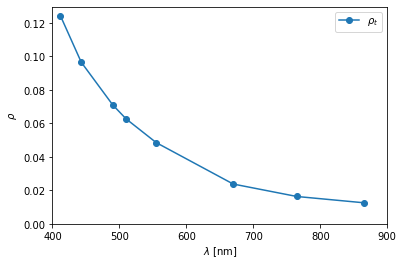

In [7]:
satellite=widgets.Dropdown(options=list_satellite.keys(), description="Satélite");

chl = widgets.BoundedFloatText(value=5, min=0.001, max=100, description="Chla [mg/m3]");
wind = widgets.BoundedFloatText(value=0, min=0, max=30, description="W [m/s]");

aero = widgets.Dropdown(options=list_aerosols, value=3, description="Aerosol");
rh = widgets.BoundedIntText(value=80, min=0, max=100, description="RH [%]");
aot = widgets.BoundedFloatText(value=0.1, min=0, max=1, description="AOT");

view = widgets.BoundedIntText(value=0, min=0, max=45, description=r"$\theta [^\circ]$");
sun = widgets.BoundedIntText(value=30, min=30, max=65, description=r"$\theta_0[^\circ]$");
phi = widgets.BoundedIntText(value=90, min=0, max=270, description=r"$\phi[^\circ]$");

toa = widgets.Checkbox(description="Mostrar TOA", value=True)
too = widgets.Checkbox(description="Mostrar TOO")
rayleigh = widgets.Checkbox(description="Mostrar Rayleigh")
aerosol = widgets.Checkbox(description="Mostrar aerosol")
glint = widgets.Checkbox(description="Mostrar glint")

button=widgets.Button(description='Run')

grid = GridspecLayout(5, 3)

grid[0, 0] = satellite; grid[1, 0] = chl; grid[1, 1] = wind;
grid[2, 0] = aero; grid[3, 0] = rh; grid[4, 0] = aot;
grid[2, 1] = view; grid[3, 1] = sun; grid[4, 1] = phi;
grid[0,2] = toa; grid[1,2] = too; grid[2,2] = rayleigh; grid[3,2] = aerosol; grid[4,2] = glint

#grid[:, 0].layout.height = 'auto'
display(grid, button)
button.on_click(click)